<a href="https://colab.research.google.com/github/ThisuriLekamge/NeuralStyleTransfer_PyTorch/blob/master/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [58]:
from google.colab import files
dancer = files.upload()

Saving dancing.jpg to dancing (1).jpg


In [60]:
from google.colab import files
picasso = files.upload()

Saving pablo.jpg to pablo.jpg


In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')  
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
	
  if shape is not None:
    size = shape
  
  in_transform = transforms.Compose([
    transforms.Resize((size, int(1.5*size))),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  
  image = in_transform(image)[:3, :, :].unsqueeze(0)
  
  return image

In [63]:
content = load_image("./dancing.jpg")#normalized imgs
print(content.shape)

style = load_image("./pablo.jpg")
print(style.shape)

torch.Size([1, 3, 400, 600])
torch.Size([1, 3, 225, 337])


In [0]:
def im_convert(tensor): # back to original imgs
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array(
    (0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

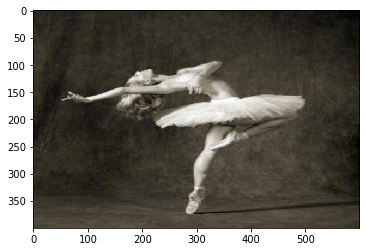

In [65]:
x = im_convert(content)
plt.figure()
plt.imshow(x)

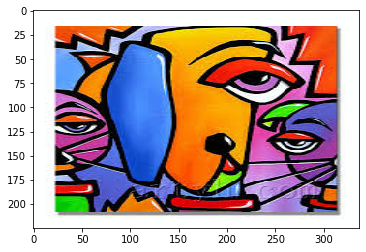

In [80]:
y = im_convert(style)
plt.figure()
plt.imshow(y)

In [0]:
def get_features(image, model, layers=None):
  if layers is None:
    layers = {'0': 'conv1_1','5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content layer
              '28': 'conv5_1'}
  features = {}
  x = image
  for name, layer in enumerate(model.features):
    x = layer(x)
    if str(name) in layers:
      features[layers[str(name)]] = x
  
  return features

In [0]:
def gram_matrix(tensor):
  _, n_filters, h, w = tensor.size()
  tensor = tensor.view(n_filters, h * w)
  gram = torch.mm(tensor, tensor.t())
  
  return gram

In [0]:
vgg = models.vgg19(pretrained=True)

In [0]:
for param in vgg.parameters():
  param.requires_grad_(False)

In [0]:
for i, layer in enumerate(vgg.features):
  if isinstance(layer, torch.nn.MaxPool2d):
    vgg.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [71]:
vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style,vgg)

style_grams = {
  layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
content_img = im_convert(content)
style_img = im_convert(style)

In [0]:
target = content.clone().requires_grad_(True)

In [0]:
style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [0]:
content_weight = 1e4
style_weight = 1e2

In [0]:
optimizer = optim.Adam([target], lr=0.01)

In [78]:
num_iterations = 100
for i in range(1, num_iterations + 1):
  optimizer.zero_grad()
  target_features = get_features(target, vgg)
  
  content_loss = torch.mean((target_features['conv4_2'] -
                             content_features['conv4_2']) ** 2)
  
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean(
      (target_gram - style_gram) ** 2)
    style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
  if i % 50 == 0:
    total_loss_rounded = round(total_loss.item(), 2)
    content_fraction = round(
      content_weight*content_loss.item()/total_loss.item(), 2)
    style_fraction = round(
      style_weight*style_loss.item()/total_loss.item(), 2)
    print('Iteration {}, Total loss: {} - (content: {}, style {})'.format(
      i,total_loss_rounded, content_fraction, style_fraction))
      
final_img = im_convert(target)

Iteration 50, Total loss: 2264.22 - (content: 0.11, style 0.89)
Iteration 100, Total loss: 1765.03 - (content: 0.15, style 0.85)


(-0.5, 599.5, 399.5, -0.5)

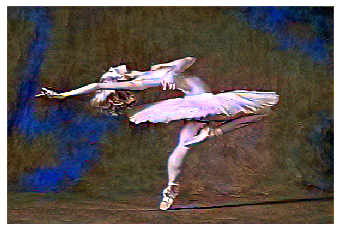

In [79]:
fig = plt.figure()
plt.imshow(final_img)
plt.axis('off')
